# LIM forecasting: multivariate separate sic each month

Katie Brennan  
started March 2021  
  
#### Goals: 
* Debug why eigenvalues are positive...

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

import time as timestamp 

In [2]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb
import LIM_building as limbuild

In [76]:
import importlib
importlib.reload(limkb)
importlib.reload(statskb)
importlib.reload(limbuild)

<module 'LIM_building' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py'>

In [4]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [5]:
valid_stats_allmo = {}

In [124]:
# number of EOFs to retain for the LIM state vector
ntrunc = 400 # EOF truncation for individual fields (reduced-state space)
nmodes = 30 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 30
#modes_sic = 20

mo='all'
#mo=1

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 0.6

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
limvars = ['tas']
limvars_nosic = ['tas','tos']
nvars = len(limvars)

# specify the model source 
train_dsource = 'mpi_lm_kb'
#train_dsource = 'ccsm4_lm_kb'
valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = False
Insamp = True

In [7]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_train = limkb.build_training_dic(train_dsource)
fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names()
areacell, areacell_dict = limbuild.load_areacell_dict(fdic_train, remove_climo=False, 
                                                      detrend=False, verbose=False )

In [ ]:
def load_training_valid_data_full(limvars, fdic_train, mo, areacell, ntrain, areawt_name, 
                                  ntrunc,nmodes_sic, sic_separate=False,
                                  remove_climo=True, detrend=True, wt=True, verbose=True): 

    var_dict = {}
    v = {}
    tot_var = {}
    tot_var_eig = {}
    W_all = {}
    E3 = {}
    Ptrunc = {}
    Ptrunc_valid = {}
    standard_factor = {}

    for k, var in enumerate(limvars): 

        X_var, v = limkb.load_data(var, var_dict, fdic_train, remove_climo=True, 
                                   detrend=True, verbose=True)
        var_dict[var] = v[var]
        
        if mo is 'all':
            X_t = X_var
            ntime = X_t.shape[1]
            nyears_train = int(ntime*ntrain)
            nyears_valid = ntime - nyears_train

            X_train = X_t[:,0:nyears_train]
            X_train_2d = X_train
            X_valid = X_t[:,nyears_train:]
        else: 
            tsamp = X_var.shape[1]
            nyears_train = int((tsamp*ntrain)/12)
            nyears_valid = int((tsamp*(1-ntrain))/12)

            X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))

            X_train = X_t[:,0:nyears_train,mo:mo+2]
            X_train_2d = np.reshape(X_train,(X_train.shape[0],nyears_train*2))
            X_valid = X_t[:,nyears_train:,mo]

        acell = areacell[areawt_name[var]]
        if len(acell.shape)>1:
            acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
        else: 
            acell_1d = acell
            
        [Ptrunc[var], E3[var], tot_var[var],
         tot_var_eig[var], W_all[var], 
         standard_factor[var]] = limkb.step1_compress_individual_var(X_train_2d, var, ntrunc, nmodes_sic, 
                                                                     var_dict, areawt=acell_1d,
                                                                     wt=wt, sic_separate=sic_separate)
        
        Ptrunc_valid[var] = limkb.step1_projection_validation_var(X_valid, E3[var], standard_factor[var], 
                                                                  W_all[var])

        del X_var
    
    return Ptrunc, Ptrunc_valid, E3, tot_var, tot_var_eig, W_all, standard_factor, nyears_train, var_dict

## Build L from scratch: 

In [125]:
# wt=True
# var_dict = {}
# v = {}
# tot_var = {}
# tot_var_eig = {}
# W_all = {}
# E3 = {}
# Ptrunc = {}
# Ptrunc_valid = {}
# standard_factor = {}

# for k, var in enumerate(limvars): 

#     X_var, v = limkb.load_data(var, var_dict, fdic_train, remove_climo=True, 
#                                detrend=True, verbose=True)
#     var_dict[var] = v[var]

#     if mo is 'all':
#         X_t = X_var
#         ntime = X_t.shape[1]
#         nyears_train = int(ntime*ntrain)
#         nyears_valid = ntime - nyears_train

#         X_train = X_t[:,0:nyears_train]
#         X_valid = X_t[:,nyears_train:]
        
#         print('detrending training data...')
#         var_nans_mask = np.where(np.isnan(X_train),np.nan,1)
#         Y = np.where(np.isnan(X_train),0,X_train)
#         print(Y.shape)
#         X = np.arange(0,nyears_train,1)
#         [train_dt,_,_] = statskb.multi_linear_detrend(X,Y,axis=1,remove_mn=False)
#         X_train_dt = train_dt*var_nans_mask
        
#         X_train_2d = X_train_dt
#     else: 
#         tsamp = X_var.shape[1]
#         nyears_train = int((tsamp*ntrain)/12)
#         nyears_valid = int((tsamp*(1-ntrain))/12)

#         X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))

#         X_train = X_t[:,0:nyears_train,mo:mo+2]
#         x_train_2d = np.reshape(X_train,(X_train.shape[0],nyears_train*2))
#         X_valid = X_t[:,nyears_train:,mo]
        
#         print('detrending training data...')
#         X_train_dt = np.zeros_like(x_train_2d)
#         for m in range(2):
#             var_nans_mask = np.where(np.isnan(x_train_2d[:,:,m]),np.nan,1)
#             Y = np.where(np.isnan(X_train),0,x_train_2d[:,:,m])
#             print(Y.shape)
#             X = np.arange(0,nyears_train,1)
#             [train_dt,_,_] = statskb.multi_linear_detrend(X,Y,axis=1,remove_mn=False)
#             X_train_dt[:,:,m] = train_dt*var_nans_mask
            
#         X_train_2d = X_train_dt    

#     acell = areacell[areawt_name[var]]
#     if len(acell.shape)>1:
#         acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
#     else: 
#         acell_1d = acell

[Ptrunc[var], E3[var], tot_var[var],
 tot_var_eig[var], W_all[var], 
 standard_factor[var]] = limkb.step1_compress_individual_var(X_train_2d[:,0:4000], var, ntrunc, nmodes_sic, 
                                                             var_dict, areawt=acell_1d,
                                                             wt=wt, sic_separate=sic_separate)

Ptrunc_valid[var] = limkb.step1_projection_validation_var(X_valid, E3[var], standard_factor[var], 
                                                          W_all[var])

fraction in first 400 tas EOFs = 93.61727429083982


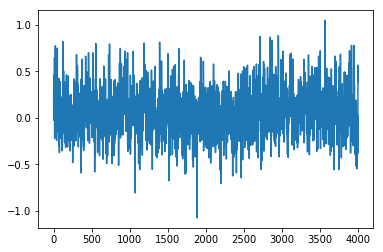

In [126]:
neof = 3
plt.plot(Ptrunc['tas'][neof,:])

In [18]:
from scipy.stats import linregress

slope = np.zeros((18432))
slope2 = np.zeros((18432))

for i in range(18432):
    [slope[i],_] = statskb.calc_linear_fit(np.arange(0,12000,1),X_var[i,:])
    [slope2[i],_,_,_,_] = linregress(np.arange(0,12000,1),X_var[i,:])

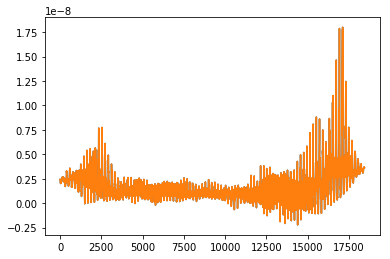

In [21]:
plt.plot(slope)
plt.plot(slope2)

In [33]:
X_train_2d.shape

(18432, 7200)

In [34]:
slope_train = np.zeros((18432))
slope_train2 = np.zeros((18432))

for i in range(18432):
    [slope_train[i],_] = statskb.calc_linear_fit(np.arange(0,7200,1),X_train_2d[i,:])
    [slope_train2[i],_,_,_,_] = linregress(np.arange(0,7200,1),X_train_2d[i,:])

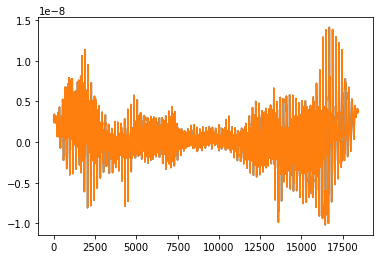

In [35]:
plt.plot(slope_train)
plt.plot(slope_train2)

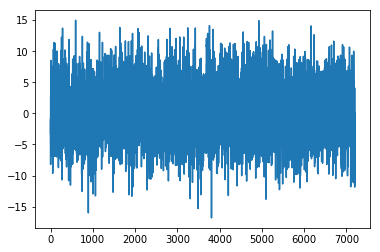

In [50]:
plt.plot(X_train_2d[1070,:])

In [54]:
var_dict = limbuild.get_var_incices(limvars, var_dict)

working on tas


In [ ]:
Ptrun

In [128]:
## Start with full training data: 
# [Ptrunc, Ptrunc_valid, E3, tot_var, 
#  tot_var_eig, W_all,standard_factor, nyears_train, 
#  var_dict] = limbuild.load_training_valid_data_full(limvars, fdic_train, mo, areacell, ntrain, 
#                                                     areawt_name, ntrunc, nmodes_sic, 
#                                                     sic_separate=sic_separate,
#                                                     remove_climo=True,detrend=True, 
#                                                     wt=True, verbose=True)

## Start with truncated training data: 
mod_folder = 'truncated_model_data/'
mod_filename = '_ANNUAL_ntrunc30_mpi_lm_kb_20210420.pkl'
mod_sic_filename = '_ntrunc30_mpi_lm_kb_20210420.pkl'

[Ptrunc, Ptrunc_valid, E3, tot_var, 
 tot_var_eig, W_all, standard_factor, 
 nyears_train, var_dict] = limbuild.load_training_data_truncated(limvars, mod_folder, mod_sic_filename, 
                                                                 mod_filename, mo, ntrain)

var_dict = limbuild.get_var_incices(limvars, var_dict)

Loading truncated tas
working on tas


In [129]:
Ptrunc['tas'].shape

(30, 600)

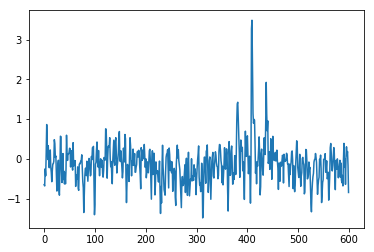

In [151]:
neof=0
plt.plot(Ptrunc['tas'][neof,:])

In [53]:
ndof_all = limkb.count_ndof_all(limvars, E3, sic_separate=sic_separate)

# [Ptrunc_all, E3_all, 
# Ptrunc_sic,E_sic] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
#                                               var_dict, sic_separate=sic_separate)

# [P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all,nmodes, E3_all, Ptrunc_sic, 
#                                                        sic_separate=sic_separate, Trunc_truth=False)

[Ptrunc_all, E3_all] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
                                                 var_dict, sic_separate=sic_separate)

[P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all,nmodes, E3_all, 0, 
                                                       sic_separate=sic_separate, Trunc_truth=False)

18432
Fraction in first 30 multivariate EOFs = 61.636672946437926
Shape of E: (18432, 30)


In [55]:
ndof_all_valid = limkb.count_ndof_all(limvars, E3, sic_separate=sic_separate)

[Ptrunc_all_valid, E3_all_valid,
 Ptrunc_sic_valid, E_sic_valid] = limkb.stack_variable_eofs(limvars, ndof_all_valid, ntrunc, Ptrunc_valid,
                                                            E3, var_dict, sic_separate=sic_separate)

[P_train_valid, Fvar_valid, 
 E_valid] = limkb.step2_multivariate_compress(Ptrunc_all_valid,nmodes, E3_all_valid, Ptrunc_sic_valid,
                                              sic_separate=sic_separate, Trunc_truth=False)

18432


ValueError: not enough values to unpack (expected 4, got 2)

In [56]:
neof = 0
plt.plot(P_train_3d[neof,:,0])
plt.plot(P_train_3d[neof,:,1])

SyntaxError: invalid syntax (<ipython-input-56-5d9077d807e7>, line 1)

In [127]:
Ptrunc['tas'].shape

(400, 4000)

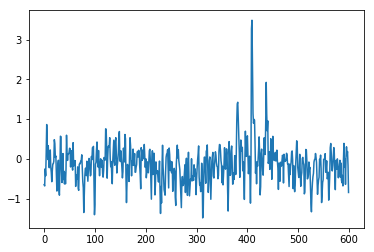

In [137]:
neof =0
plt.plot(Ptrunc['tas'][neof,:])

In [143]:
nmo = int(P_train.shape[1]/nyears_train)
#P_train_3d = np.reshape(P_train, (P_train.shape[0],nyears_train,nmo))

if mo is 'all':
    print('Using all months...')
    LIMd2, G2 = lim.LIM_train(tau,Ptrunc['tas'])
    print('Training LIM with tau = '+str(tau))
else: 
    print('Using months '+str(mo)+' and '+str(mo+1))
    LIMd2, G2 = lim.LIM_train_flex(tau,P_train_3d[:,:,0], P_train_3d[:,:,1])
    print('Training LIM with tau = '+str(tau))

Using all months...
Training LIM with tau = 1


In [144]:
G2.shape, Ptrunc['tas'].shape

((30, 30), (30, 600))

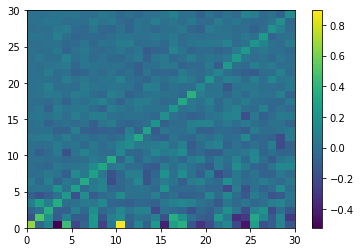

In [145]:
plt.pcolormesh(G2)
plt.colorbar()

In [146]:
G2.shape

(30, 30)

In [166]:
LIMd2['val']

array([ 0.8974005 +0.j        ,  0.26124549+0.42262452j,
        0.26124549-0.42262452j,  0.72322626+0.j        ,
        0.17823551+0.35354689j,  0.17823551-0.35354689j,
        0.61646755+0.j        ,  0.53620637+0.14917171j,
        0.53620637-0.14917171j,  0.53854578+0.01164876j,
        0.53854578-0.01164876j,  0.29996543+0.19328875j,
        0.29996543-0.19328875j, -0.03289145+0.09066106j,
       -0.03289145-0.09066106j, -0.03812812+0.j        ,
        0.35928571+0.j        ,  0.07170651+0.14638688j,
        0.07170651-0.14638688j,  0.13123787+0.14464649j,
        0.13123787-0.14464649j,  0.28095952+0.10664788j,
        0.28095952-0.10664788j,  0.04358194+0.j        ,
        0.08444114+0.04364159j,  0.08444114-0.04364159j,
        0.28425808+0.j        ,  0.19802761+0.06098995j,
        0.19802761-0.06098995j,  0.20065726+0.j        ])

In [159]:
nt = Ptrunc['tas'].shape[1]
C_0 = np.matmul(Ptrunc['tas'],Ptrunc['tas'].T)/(nt-1)
C_1 = np.matmul(Ptrunc['tas'][:,tau:],Ptrunc['tas'][:,:-tau].T)/(nt-1)

In [165]:
np.diag(np.matmul(np.linalg.inv(C_0), C_0))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [168]:
G = np.matmul(C_1, np.linalg.inv(C_0))
val,vec = np.linalg.eig(G)

In [169]:
val

array([ 0.8974005 +0.j        ,  0.26124549+0.42262452j,
        0.26124549-0.42262452j,  0.72322626+0.j        ,
        0.17823551+0.35354689j,  0.17823551-0.35354689j,
        0.61646755+0.j        ,  0.53620637+0.14917171j,
        0.53620637-0.14917171j,  0.53854578+0.01164876j,
        0.53854578-0.01164876j,  0.29996543+0.19328875j,
        0.29996543-0.19328875j, -0.03289145+0.09066106j,
       -0.03289145-0.09066106j, -0.03812812+0.j        ,
        0.35928571+0.j        ,  0.07170651+0.14638688j,
        0.07170651-0.14638688j,  0.13123787+0.14464649j,
        0.13123787-0.14464649j,  0.28095952+0.10664788j,
        0.28095952-0.10664788j,  0.04358194+0.j        ,
        0.08444114+0.04364159j,  0.08444114-0.04364159j,
        0.28425808+0.j        ,  0.19802761+0.06098995j,
        0.19802761-0.06098995j,  0.20065726+0.j        ])

In [170]:
lam_L = np.log(val)/tau
lam_L

array([-0.10825302+0.j        , -0.69946555+1.01713777j,
       -0.69946555-1.01713777j, -0.32403315+0.j        ,
       -0.92650911+1.10384585j, -0.92650911-1.10384585j,
       -0.48374959+0.j        , -0.58596345+0.27133723j,
       -0.58596345-0.27133723j, -0.61864889+0.02162666j,
       -0.61864889-0.02162666j, -1.03044807+0.57240727j,
       -1.03044807-0.57240727j, -2.33880192+1.9188247j ,
       -2.33880192-1.9188247j , -3.26680331+3.14159265j,
       -1.02363736+0.j        , -1.81396851+1.11530772j,
       -1.81396851-1.11530772j, -1.63316737+0.83396228j,
       -1.63316737-0.83396228j, -1.20224235+0.36278389j,
       -1.20224235-0.36278389j, -3.13311241+0.j        ,
       -2.35333048+0.4770196j , -2.35333048-0.4770196j ,
       -1.25787273+0.j        , -1.57403738+0.29876822j,
       -1.57403738-0.29876822j, -1.60615701+0.j        ])

## Run Forecast: 

In [75]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = [0,1,2,3,4,5,6,7,8,9,10,11]
#lags = [0,1,2,3]
ntims = len(lags)

if mo == 'all':
    if Insamp==True: 
        LIM_fcast = limkb.LIM_forecast_Gt(LIMd2,P_train[:,0:nyears_train],lags)
    else: 
        LIM_fcast = limkb.LIM_forecast_Gt(LIMd2,P_train_valid,lags)
else: 
    if Insamp==True: 
        P_train_2d = np.reshape(P_train, (P_train.shape[0],int(P_train.shape[1]/2),2))
        LIM_fcast = limkb.LIM_forecast_Gt(LIMd2,P_train_2d[:,:,0],lags)
    else: 
        LIM_fcast = limkb.LIM_forecast_Gt(LIMd2,P_train_valid,lags)
    
#LIM_fcast = LIM_forecast_Gt(LIMd2,P_train_valid,lags)

t= 0
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11


In [76]:
P_train.shape

(80, 1200)

In [60]:
LIMd2['Gt'].shape

(80, 80)

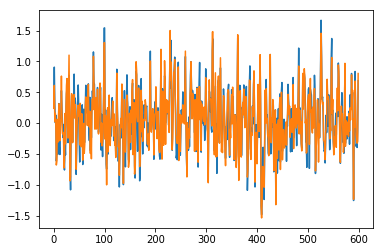

In [37]:
plt.plot(P_train_3d[0,:,0])
plt.plot(P_train_3d[0,:,1])

In [64]:
LIMd2['val'].shape

(80,)

In [63]:
LIMd2['val']

array([ 1.55616476+0.418015j  ,  1.55616476-0.418015j  ,
        1.30543633+0.j        , -0.02420255+0.04304071j,
       -0.02420255-0.04304071j,  0.01984478+0.05715776j,
        0.01984478-0.05715776j,  0.07094526+0.18078936j,
        0.07094526-0.18078936j,  0.40640662+0.43927785j,
        0.40640662-0.43927785j,  0.30148503+0.38389938j,
        0.30148503-0.38389938j,  1.10462766+0.02983589j,
        1.10462766-0.02983589j,  0.09573102+0.j        ,
        0.95173147+0.23109305j,  0.95173147-0.23109305j,
        0.12812785+0.02974782j,  0.12812785-0.02974782j,
        0.55928788+0.41345567j,  0.55928788-0.41345567j,
        0.18186836+0.20038016j,  0.18186836-0.20038016j,
        0.19614504+0.19830596j,  0.19614504-0.19830596j,
        0.69892572+0.40241308j,  0.69892572-0.40241308j,
        1.00831279+0.j        ,  0.90313933+0.26942869j,
        0.90313933-0.26942869j,  0.76925319+0.34550288j,
        0.76925319-0.34550288j,  0.23675712+0.14393115j,
        0.23675712-0.14393115j,

## Decompress forecast and validate:

In [171]:
x_forecast_dcomp = np.zeros((len(lags),E.shape[0]+E_sic.shape[0],LIM_fcast['x_forecast'].shape[2]))

for i,lag in enumerate(lags):
    print('Lag '+ str(lag))
    x_forecast_dcomp[i,:,:] = limkb.decompress_eof_separate_sic(LIM_fcast['x_forecast'][i,:,:],
                                                                nmodes,nmodes_sic,E,
                                                                E_sic,limvars,var_dict,
                                                                W_all,Weights=True,
                                                                sic_separate=sic_separate)

NameError: name 'lags' is not defined

In [ ]:
gm_tas = np.zeros((12,600))

for l in lags:
    gm_tas[l,:] = statskb.global_mean(x_forecast_dcomp[l,var_dict['tas']['var_inds'],:],areacell[areawt_name['tas']])

In [ ]:
plt.plot(gm_tas[11,:])
plt.plot(gm_tas[1,:])
plt.plot(gm_tas[0,:])

In [ ]:
lags_test = [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
validvars = ['tas']
v = {}
validation_stats_test = {}

for k, var in enumerate(validvars):
    X_var, _ = limkb.load_data(var, v, fdic_train, remove_climo=True, detrend=True, verbose=True)
    
    corr_tot = np.zeros((len(lags)))
    ce_tot = np.zeros((len(lags)))
    gm_var_ratio = np.zeros((len(lags)))
    valid_stats_test = {}

    for i,lag in enumerate(lags_test):
        print('Lag '+str(lag))
        [truth_anom, forecast_anom] = limbuild.gather_truth_forecast(lag,var,mo,X_var,x_forecast_dcomp,
                                                                     var_dict,ntrain,insamp=Insamp)
        print('Truth_anom shape: '+str(truth_anom.shape))
        print('Forecast_anom shape: '+str(forecast_anom.shape))
        
        if lag == 0: 
            truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)
#            truth_error_var = np.where(truth_var<1,0,truth_var)
#            gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])           
        
        error_var = np.nanvar(truth_anom-forecast_anom,axis=1,ddof=1)
        ratio = error_var/truth_error_var
        
        area_shape = areacell[areawt_name[var]].shape
        gm_var_ratio[i] = statskb.global_mean(ratio[np.isfinite(ratio)],
                                              np.reshape(areacell[areawt_name[var]],(area_shape[0]*area_shape[1]))[np.isfinite(ratio)])

#         truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)
#         error_var = np.nanvar(truth_anom-forecast_anom,axis=1,ddof=1)
        
#         area_shape = areacell[areawt_name[var]].shape
#         gm_truth_var = statskb.global_mean(truth_error_var[truth_error_var>0],
#                                            np.reshape(areacell[areawt_name[var]],(area_shape[0]*area_shape[1]))[truth_error_var>0])
#         gm_error_var = statskb.global_mean(error_var[truth_error_var>0],
#                                            np.reshape(areacell[areawt_name[var]],(area_shape[0]*area_shape[1]))[truth_error_var>0])

#         gm_var_ratio[i]=gm_error_var/gm_truth_var
#         print(gm_error_var)
#         print(gm_truth_var)
        
    valid_stats_test['gm_var_ratio'] = gm_var_ratio
    validation_stats_test[var] = valid_stats_test

In [ ]:
np.reshape(areacell[areawt_name[var]],(area_shape[0]*area_shape[1])).shape

In [ ]:
testing = x_forecast_dcomp[lag,var_dict[var]['var_inds'],:]

In [ ]:
plt.plot(error_var)
plt.plot(truth_error_var)
#plt.xlim(24800,24850)

In [ ]:
#plt.pcolormesh(np.reshape(testing[:,yr], (220,256)))
plt.pcolormesh(np.reshape(error_var, (96,192)))
plt.colorbar()

In [ ]:
#plt.pcolormesh(np.reshape(testing[:,yr], (220,256)))
plt.pcolormesh(np.reshape(truth_error_var, (96,192)))
plt.colorbar()

In [ ]:
plt.plot(truth_anom[24820,:])
#plt.plot(testing[24820,:])
plt.plot(forecast_anom[24820,:])
plt.xlim(0,10)

In [ ]:
yr =400
#plt.pcolormesh(np.reshape(testing[:,yr], (220,256)))
plt.pcolormesh(np.reshape(forecast_anom[:,yr], (96,192)))
plt.colorbar()

In [ ]:
# forecast_anom_c = np.where(forecast_anom>100,100,forecast_anom)
# forecast_anom_cut = np.where(forecast_anom<-100,-100,forecast_anom_c)
plt.pcolormesh(np.reshape(forecast_anom_cut[:,yr], (96,192)))
plt.colorbar()

In [ ]:
yr =0
#plt.pcolormesh(np.reshape(testing[:,yr], (220,256)))
plt.pcolormesh(np.reshape(truth_anom[:,yr], (220,256)))
plt.colorbar()

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(validation_stats_test[var]['gm_var_ratio'])

#    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,11)
    ax[i].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
    ax[i].grid(axis='both')
    ax[i].set_ylabel('GM ratio: \nerror variance to true variance (1 lag only)', fontsize=14)
    ax[i].set_title(var, fontsize=16)
if mo == 'all':
    plt.suptitle('All months', fontsize=16)
else: 
    plt.suptitle(month_names[mo], fontsize=16)
    
ax[2].set_xlabel('lead time (months)', fontsize=14)
ax[3].set_xlabel('lead time (months)', fontsize=14)

In [ ]:
validation_stats_test[var]['gm_var_ratio']

In [ ]:
latvals = np.reshape(var_dict['sic']['lat'],var_dict['sic']['lat'].shape[0]*var_dict['sic']['lat'].shape[1])
latvals.shape

In [ ]:
plt.plot(truth_var)
plt.plot(truth_error_var)

In [ ]:
truth_error_var[24588], error_var[24588], error_var[24588]/truth_error_var[24588]

In [ ]:
plt.plot(truth_anom[24588,:])
plt.plot(forecast_anom[24588,:])

In [ ]:
plt.plot(truth_anom[6270,:])
plt.plot(forecast_anom[6270,:])

In [ ]:
plt.plot(error_var)
plt.plot(truth_error_var)

#### Validate all variables: 

In [ ]:
validvars = ['tas','tos','sic']
v = {}
validation_stats = {}

for k, var in enumerate(validvars):
    X_var, _ = limkb.load_data(var, v, fdic_train, remove_climo=True, detrend=True, verbose=True)
    
    corr_tot = np.zeros((len(lags)))
    ce_tot = np.zeros((len(lags)))
    gm_var_ratio = np.zeros((len(lags)))
    valid_stats = {}

    for i,lag in enumerate(lags):
        print('Lag '+str(lag))
        [truth_anom, forecast_anom] = limbuild.gather_truth_forecast(lag,var,mo,X_var,x_forecast_dcomp,
                                                                     var_dict,ntrain,insamp=Insamp)
        print('Truth_anom shape: '+str(truth_anom.shape))
        print('Forecast_anom shape: '+str(forecast_anom.shape))

        [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_var_forecast, 
         tot_var_truth] = limbuild.calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,
                                                             areacell,areacell_dict,
                                                             areawt_name,month_names,iplot=True)
        
    valid_stats['corr_tot'] = corr_tot
    valid_stats['ce_tot'] = ce_tot
    valid_stats['gm_var_ratio'] = gm_var_ratio
    
    validation_stats[var] = valid_stats
    
valid_stats_allmo[mo] = validation_stats

#### Validate SIC: 

In [ ]:
# validvars = ['sic']
# v = {}
# validation_stats = {}

# for k, var in enumerate(validvars):
#     X_var, _ = limkb.load_data(var, v, fdic_train, remove_climo=True, detrend=True, verbose=True)
    
#     corr_tot = np.zeros((len(lags)))
#     ce_tot = np.zeros((len(lags)))
#     gm_var_ratio = np.zeros((len(lags)))
#     valid_stats = {}

#     for i,lag in enumerate(lags):
#         print('Lag '+str(lag))
#         [truth_anom, forecast_anom] = limbuild.gather_truth_forecast(lag,var,mo,X_var,x_forecast_dcomp,
#                                                                      var_dict,ntrain,insamp=Insamp)
#         print(truth_anom.shape)
#         print(forecast_anom.shape)

#         [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_nh_sic_forecast, 
#          tot_nh_sic_truth] = limbuild.calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,
#                                                              areacell,areacell_dict,
#                                                              areawt_name,month_names,iplot=True)
        
#     valid_stats['corr_tot'] = corr_tot
#     valid_stats['ce_tot'] = ce_tot
#     valid_stats['gm_var_ratio'] = gm_var_ratio
    
#     validation_stats[var] = valid_stats
    
# valid_stats_allmo[mo] = validation_stats

In [ ]:
# valid_stats['corr_tot'] = corr_tot
# valid_stats['ce_tot'] = ce_tot
# valid_stats['gm_var_ratio'] = gm_var_ratio

# validation_stats[var] = valid_stats

# valid_stats_allmo[mo] = validation_stats

### All limvar plots: 

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(validation_stats[var]['corr_tot']**2, label='Correlation')
    ax[i].plot(validation_stats[var]['ce_tot'],label='CE')

    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,11)
    ax[i].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
if mo == 'all':
    plt.suptitle('All months', fontsize=16)
else: 
    plt.suptitle(month_names[mo], fontsize=16)
ax[0].legend(loc='upper right')
ax[2].set_xlabel('lead time (months)', fontsize=14)
ax[3].set_xlabel('lead time (months)', fontsize=14)

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(validation_stats[var]['gm_var_ratio'])

#    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,11)
    ax[i].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
    ax[i].grid(axis='both')
    ax[i].set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)
    ax[i].set_title(var, fontsize=16)
if mo == 'all':
    plt.suptitle('All months', fontsize=16)
else: 
    plt.suptitle(month_names[mo], fontsize=16)
    
ax[2].set_xlabel('lead time (months)', fontsize=14)
ax[3].set_xlabel('lead time (months)', fontsize=14)

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(validation_stats_test[var]['gm_var_ratio'])

#    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,11)
    ax[i].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
    ax[i].grid(axis='both')
    ax[i].set_ylabel('GM ratio: \nerror variance to true variance (1 lag only)', fontsize=14)
    ax[i].set_title(var, fontsize=16)
if mo == 'all':
    plt.suptitle('All months', fontsize=16)
else: 
    plt.suptitle(month_names[mo], fontsize=16)
    
ax[2].set_xlabel('lead time (months)', fontsize=14)
ax[3].set_xlabel('lead time (months)', fontsize=14)

### Validation plots: 

In [ ]:
plt.plot(valid_stats['corr_tot']**2, label='Correlation')
plt.plot(valid_stats['ce_tot'],label='CE')
#plt.axhline(0,linestyle='--', color='k')
plt.ylim(0,1)
plt.xlim(0,4)
plt.xticks([0,1,2,3])
plt.grid(axis='both')
plt.xlabel('lead time (months)')
if mo == 'all':
    plt.title('All months')
else: 
    plt.title(month_names[mo])
plt.legend(loc='lower right')

In [ ]:
valid_stats['corr_tot']**2

In [ ]:
plt.plot(valid_stats['gm_var_ratio'])
plt.axhline(1,linestyle='--', color='k')
plt.xticks([0,1,2,3])
plt.ylim(0,1.1)
plt.xlabel('lead time (months)')
if mo == 'all':
    plt.title('All months')
else: 
    plt.title(month_names[mo])
plt.ylabel('GM ratio: error variance to true variance')

In [ ]:

plt.plot(tot_nh_sic_forecast*1e-6, label='forecast')
plt.plot((tot_nh_sic_truth-np.mean(tot_nh_sic_truth,axis=0))*1e-6, label='truth')
#plt.plot(tot_nh_sic_forecast[3:]*1e-6, label='forecast')
plt.xlim(0,50)
#plt.ylim(-20,20)
plt.legend()

## All months: 

In [ ]:
corr_plot = np.zeros((12))
ce_plot = np.zeros((12))
gm_var_ratio = np.zeros((12))

for m in range(12):
    corr_plot[m] = valid_stats_allmo[m]['sic']['corr_tot'][1]**2
    ce_plot[m] = valid_stats_allmo[m]['sic']['ce_tot'][1]
    gm_var_ratio[m] = valid_stats_allmo[m]['sic']['gm_var_ratio'][1]

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(corr_plot[:-1], label='Correlation')
plt.plot(ce_plot[:-1],label='CE')
#plt.axhline(0,linestyle='--', color='k')
plt.ylim(0,1)
#plt.xlim(0,4)
plt.grid(axis='both')
plt.xticks(np.arange(0,12,1),month_names, rotation='vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('lead time (months)', fontsize=14)
plt.title('All months separate LIM: 1 month lag', fontsize=16)
plt.legend(loc='lower left', fontsize=14)

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(gm_var_ratio[:-1])
#plt.axhline(0,linestyle='--', color='k')
plt.ylim(0,1)
#plt.xlim(0,4)
plt.grid(axis='both')
plt.xticks(np.arange(0,12,1),month_names, rotation='vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('lead time (months)', fontsize=14)
plt.ylabel('(GM error variance)/(GM variance of truth)', fontsize=14)
plt.title('All months separate LIM: 1 month lag', fontsize=16)
plt.legend(loc='lower left', fontsize=14)

In [ ]:
plt.plot(x_var_dt[1061,:])
plt.plot(x_var[1061,:])

In [ ]:
error_sic_2d = np.reshape(error_var, (var_dict['sic']['lat'].shape))
plt.pcolormesh(error_sic_2d)
plt.colorbar()
plt.title('Error Variance: SIC')

In [ ]:
error_sic_2d = np.reshape(truth_error_var, (var_dict['sic']['lat'].shape))
plt.pcolormesh(error_sic_2d)
plt.colorbar()
plt.title('Truth Variance: SIC')